# Hand pose

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import sys

In [2]:
from funcs import COLORMAP, heatmaps_to_coordinates, display_predictions
from variables import NUM_OF_KEYPOINTS, NUM_OF_CHANNELS, ORG_IMG_SIZE, CVT_IMG_SIZE, DATASET_MEAN, DATASET_STD
from models import ShallowUNet
from datasets import FreiHand

# Inference

In [3]:
# Inference parameters.
config = {
    "data_dir": "/Users/borjagq/Desktop/HandData/31000_31000_1_1_1_1_1_1_31000",
    "model_path": "/Users/borjagq/Desktop/Trinity/Dissertation/Results/31000_31000_1_1_1_1_1_1_31000/model_final",
    "test_batch_size": 4,
    "device": "cpu",
}

In [4]:
model = ShallowUNet(NUM_OF_CHANNELS, NUM_OF_KEYPOINTS)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()

ShallowUNet(
  (conv_down1): ConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): ReLU(inplace=True)
    )
  )
  (conv_down2): ConvBlock(
    (double_conv): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): ReLU(inplace=True)
    )
  )
  (conv_down3

In [5]:
# Test dataset.
test_dataset = FreiHand(config=config, dataset_type="test")
test_dataloader = DataLoader(
    test_dataset, config["test_batch_size"], shuffle=True, drop_last=False, num_workers=2,
)

In [6]:
# Init an accuracy DS and go through the data.
mean_euclidean_distance = []
mean_squared_error = []
mean_correct_keypoints = []

for data in tqdm(test_dataloader):

    # Loads the input into the model.
    inputs = data["image"]
    pred_heatmaps = model(inputs)

    # Get the prediction heatmaps and the keypoints.
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    # Get the accuracy for the keypoints.
    # This accuracy is calculated by getting the euclidian distance.
    med_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    mse_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2)

    mean_euclidean_distance.extend(list(med_keypoint.mean(axis=1)))
    mean_squared_error.extend(list(mse_keypoint.mean(axis=1)))
    mean_correct_keypoints = np.sum(med_keypoint <= 0.05, axis=1)


100%|██████████| 390/390 [00:36<00:00, 10.56it/s]


In [7]:
med_error = np.mean(mean_euclidean_distance)
mse_error = np.mean(mean_squared_error)
mck_error = np.mean(mean_correct_keypoints)
pck_error = (mck_error / 21) * 100

print("Mean Euclidian Distance: {}".format(med_error * 100))
print("Mean Squared Error: {}".format(mse_error * 100))
print("Mean Correct keypoints: {}".format(mck_error))
print("Percentage of Correct Keypoints: {}".format(pck_error))

Mean Euclidian Distance: 2.5548719534964177
Mean Squared Error: 0.16626429084676617
Mean Correct keypoints: 19.5
Percentage of Correct Keypoints: 92.85714285714286


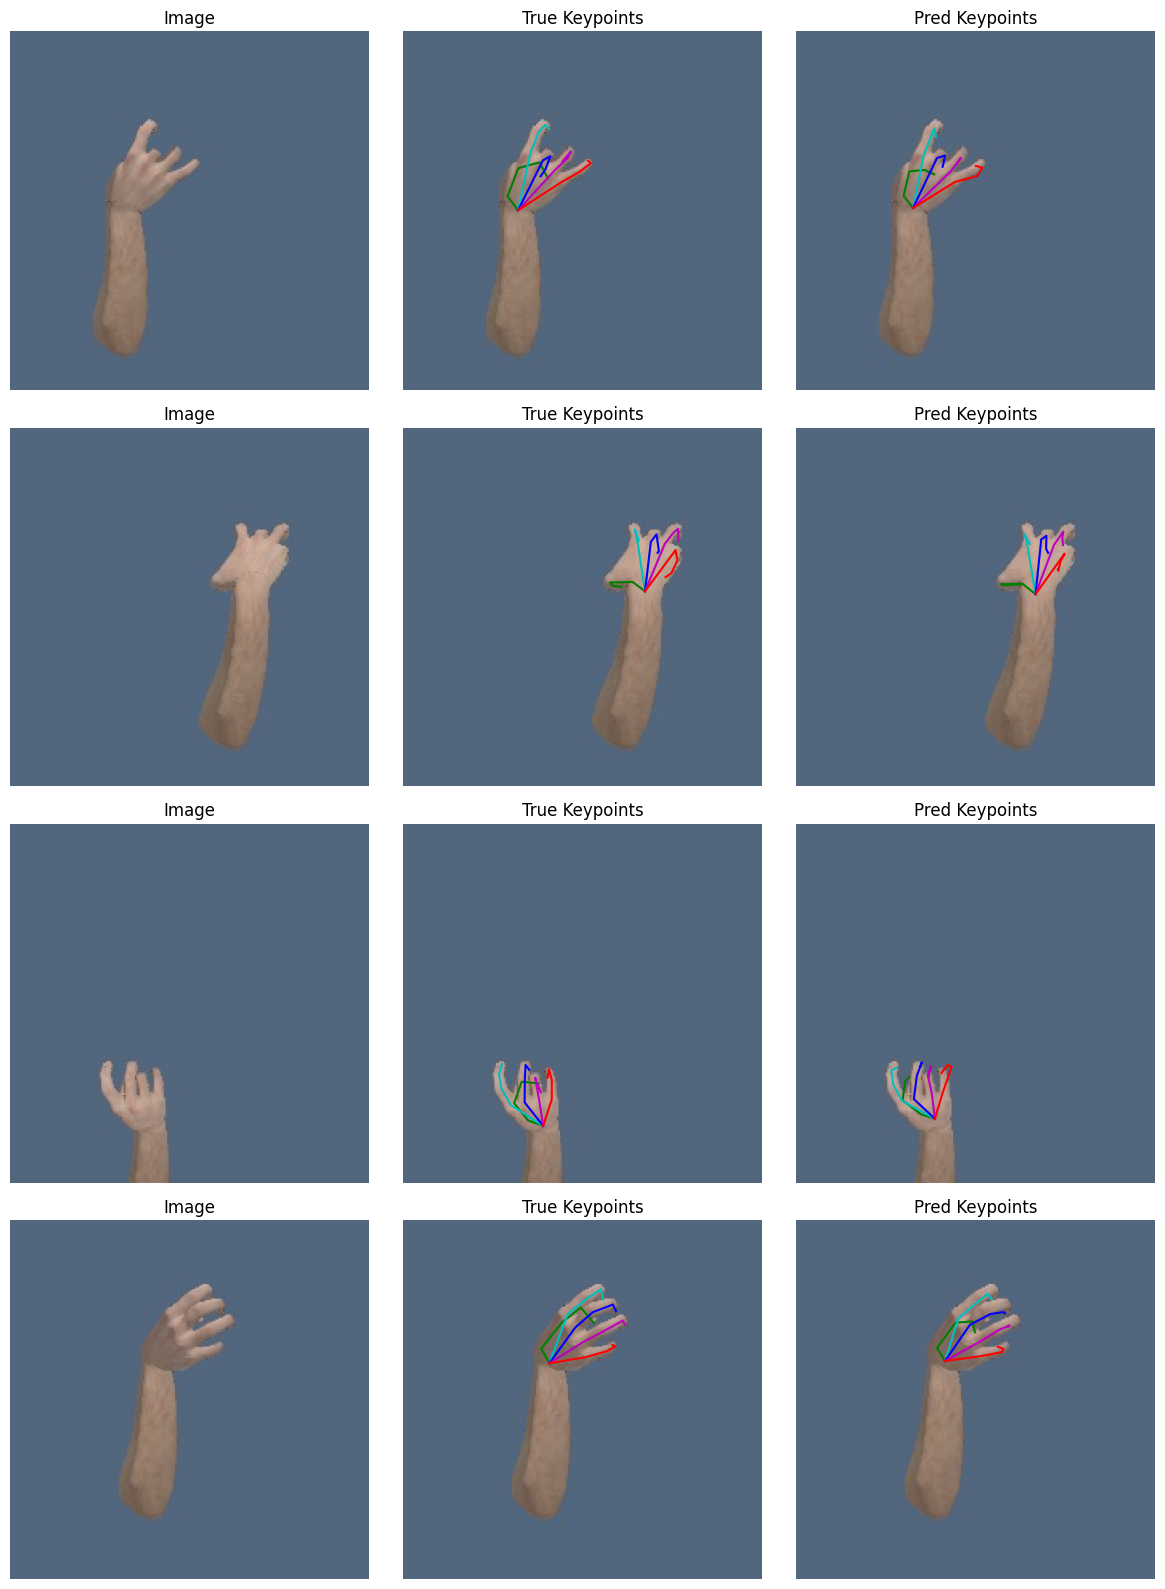

In [8]:
for data in test_dataloader:
    display_predictions(data, model)
    break